In [1]:
import tensorflow
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model as KerasModel
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.optimizers import Adam
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
basePath = "/content/drive/My Drive/Colab Notebooks/mesonet/"

In [3]:
IMGWIDTH = 256

class Classifier:
    def __init__():
        self.model = 0
    
    def predict(self, x):
        if x.size == 0:
            return []
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)


class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(learning_rate = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
    
    def init_model(self): 
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return KerasModel(inputs = x, outputs = y)


Found 19458 images belonging to 2 classes.
Predicted likelihood: 0.2526
Actual label: 0

Correct prediction: True


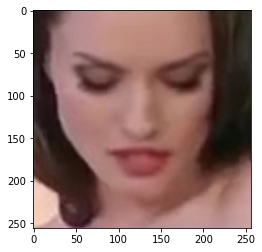

In [8]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1 - Load the model and its pretrained weights
classifier = Meso4()
classifier.load(basePath + 'weights/Meso4_DF.h5')

# 2 - Minimial image generator
# We did use it to read and compute the prediction by batchs on test videos
# but do as you please, the models were trained on 256x256 images in [0,1]^(n*n)

dataGenerator = ImageDataGenerator(rescale=1./255)
generator = dataGenerator.flow_from_directory(
        basePath + 'data',
        target_size=(256, 256),
        batch_size=1,
        class_mode='binary',
        subset='training')

# 3 - Predict
# Rendering image X with label y for MesoNet
X, y = generator.next()

# Evaluating prediction
print(f"Predicted likelihood: {classifier.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect prediction: {round(classifier.predict(X)[0][0])==y[0]}")

# Showing image
plt.imshow(np.squeeze(X));

In [ ]:
print(generator.class_indices)
print(len(generator.labels))

{'deep_fake': 0, 'real': 1}
19458


In [ ]:
# Creating separate lists for correctly classified and misclassified images
correct_real = []
correct_real_pred = []

correct_deepfake = []
correct_deepfake_pred = []

misclassified_real = []
misclassified_real_pred = []

misclassified_deepfake = []
misclassified_deepfake_pred = []

In [ ]:
for i in range(0,5000):
    
    # Loading next picture, generating prediction
    X, y = generator.next()
    pred = classifier.predict(X)[0][0]
    
    # Sorting into proper category
    if round(pred)==y[0] and y[0]==1:
        correct_real.append(X)
        correct_real_pred.append(pred)
    elif round(pred)==y[0] and y[0]==0:
        correct_deepfake.append(X)
        correct_deepfake_pred.append(pred)
    elif y[0]==1:
        misclassified_real.append(X)
        misclassified_real_pred.append(pred)
    else:
        misclassified_deepfake.append(X)
        misclassified_deepfake_pred.append(pred)   
        
    # Printing status update
    if i % 500 == 0:
        print(i, ' predictions completed.')
    
    if i == len(generator.labels)-1:
        print("All", len(generator.labels), "predictions completed")

0  predictions completed.


In [ ]:
def plotter(images,preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(0, len(images)-1, 4)
    for i,j in enumerate(subset):
        fig.add_subplot(2,2,i+1)
        plt.imshow(np.squeeze(images[j]))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show;
    return

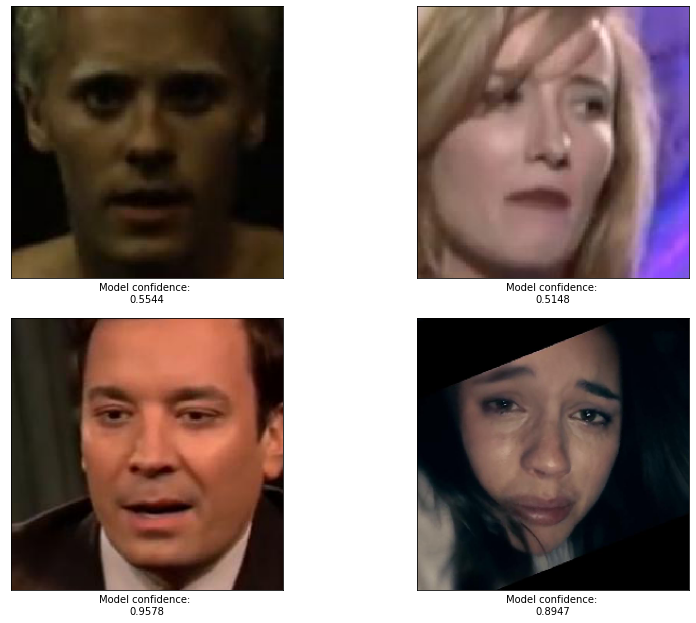

In [ ]:
plotter(correct_real, correct_real_pred)

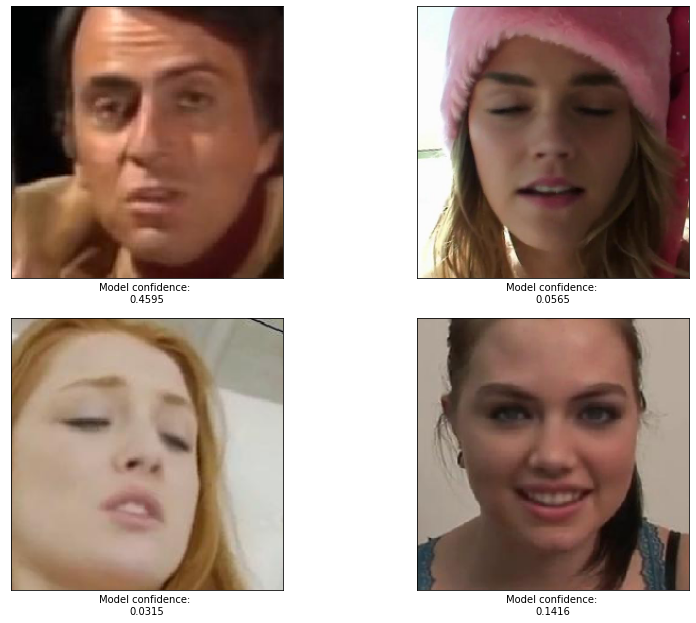

In [ ]:
plotter(misclassified_real, misclassified_real_pred)

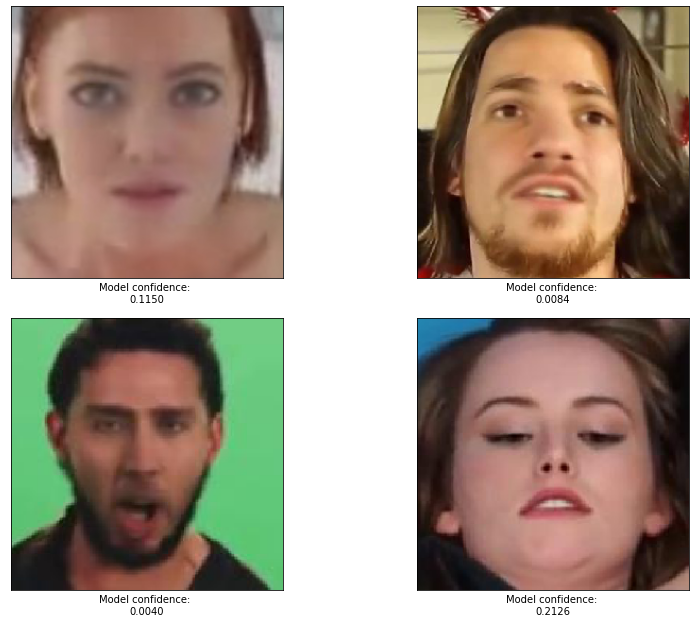

In [ ]:
plotter(correct_deepfake, correct_deepfake_pred)

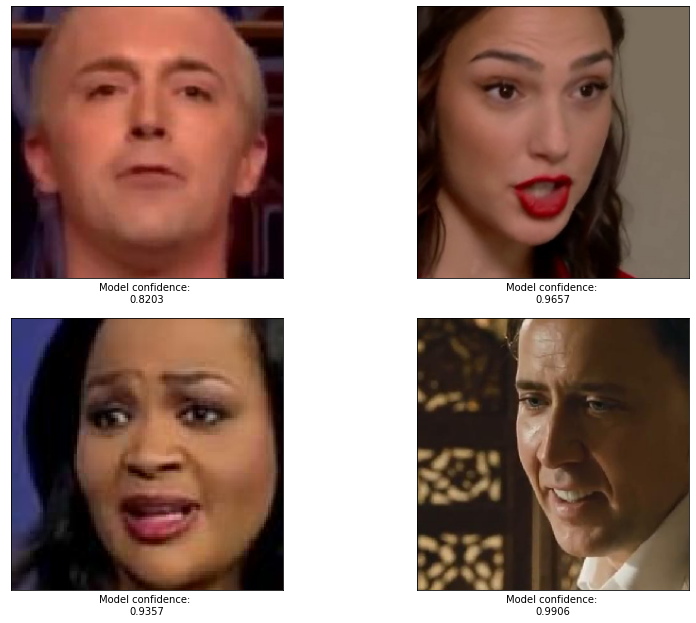

In [ ]:
plotter(misclassified_deepfake, misclassified_deepfake_pred)

#Calculate accuracy + summary#

In [10]:
dataGenerator = ImageDataGenerator(rescale=1./255)
generator = dataGenerator.flow_from_directory(
        basePath + 'data',
        target_size=(256, 256),
        batch_size=1000,
        class_mode='binary',
        subset='training')

# 3 - Predict
# Rendering image X with label y for MesoNet
X, y = generator.next()
history = classifier.fit(X,y)

Found 19458 images belonging to 2 classes.


In [14]:
print(history)

[0.39122119545936584, 0.48399999737739563]


In [ ]:
#Find total number of correct and incorrect predictions
totalCorrect = len(correct_real) + len(correct_deepfake)
totalIncorrect = len(misclassified_real) + len(misclassified_deepfake)
correct_acc = totalCorrect / 5000

In [ ]:
print("Correct accurracy percentage is ",correct_acc*100,"%")

Correct accurracy percentage is  47.760000000000005 %
